## Imports

In [445]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


# Preliminary Analysis and Baseline Modelling

## Data Download and Cleaning

In [184]:
# load a csv called data.csv with the separation character ','

geo_data = pd.read_csv('raw_data/geo_eth.csv', sep=',')
cons_data = pd.read_csv('raw_data/cons_eth.csv', sep=',')

In [251]:
# search for null values in consumption per capita column
cons_data['total_cons_ann'].isna().sum()

237

In [325]:
# search for null values in our geo-data column
geo_data.isna().sum().value_counts()

0    42
Name: count, dtype: int64

In [323]:
cons_corr = cons_data.drop(columns=['household_id','household_id2','ea_id','ea_id2']).corr()

In [326]:
# Search for correlation over 0.25 in consumption dataframe in order to ascertain if there are any relationships worth investigating.
cons_corr[cons_corr>0.25]

,saq01,rural,pw_w3,adulteq,hh_size,no_conv,no_cons,food_cons_ann,nonfood_cons_ann,educ_cons_ann,total_cons_ann,price_index_hce,nom_totcons_aeq,cons_quint
saq01,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.627601,NaN,NaN
rural,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.336731,0.299424,NaN,0.340181,0.347208,0.426672
pw_w3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adulteq,NaN,NaN,NaN,1.000000,0.978487,NaN,NaN,NaN,NaN,NaN,0.251578,NaN,NaN,NaN
hh_size,NaN,NaN,NaN,0.978487,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_conv,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_cons,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
food_cons_ann,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.282397,NaN,0.947533,NaN,0.750266,0.340953
nonfood_cons_ann,NaN,0.336731,NaN,NaN,NaN,NaN,NaN,0.282397,1.000000,0.360595,0.559812,NaN,0.441820,0.368158
educ_cons_ann,NaN,0.299424,NaN,NaN,NaN,NaN,NaN,NaN,0.360595,1.000000,0.359884,NaN,0.254274,NaN


In [29]:

# COUNTRIES_DIR = os.path.join("..", 'data', 'countries')

In [30]:
# def process_ethiopia():

#     consumption_pc_col = 'total_cons_ann' # per capita
#     hhsize_col = 'hh_size' # people in household

#     lat_col = 'lat_dd_mod'
#     lon_col = 'lon_dd_mod'

#     # purchasing power parity for ethiopia in 2015 (https://data.worldbank.org/indicator/PA.NUS.PRVT.PP?locations=ET)
#     ppp = 7.882
    
#     # for file in [consumption_file, geovariables_file]:
#     #     assert os.path.isfile(os.path.join(lsms_dir, file)), print(f'Could not find {file}')
    
#     df = cons_data
#     df['cons_ph'] = df[consumption_pc_col] * df[hhsize_col]
#     df['pph'] = df[hhsize_col]
#     df['cons_ph'] = df['cons_ph'] / ppp / 365
#     df = df[['household_id2', 'cons_ph', 'pph']]

#     df_geo = geo_data
#     df_cords = df_geo[['household_id2', lat_col, lon_col]]
#     df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)
#     df_combined = pd.merge(df, df_cords, on='household_id2')
#     df_combined.drop(['household_id2'], axis=1, inplace=True)
#     df_combined.dropna(inplace=True) # can't use na values
  
#     df_clusters = df_combined.groupby(['cluster_lat', 'cluster_lon']).sum().reset_index()
#     df_clusters['cons_pc'] = df_clusters['cons_ph'] / df_clusters['pph'] # divides total cluster income by people
#     df_clusters['country'] = 'eth'
#     return df_clusters[['country', 'cluster_lat', 'cluster_lon', 'cons_pc']]

In [205]:
# merge consumption ('cons-eth.csv') and geo-data ('geo-eth.csv') dataframes on 'household_id2'
merged_df = cons_data.merge(geo_data,how='inner',on='household_id2')
merged_df.columns

Index(['household_id', 'household_id2', 'ea_id', 'ea_id2_x', 'saq01', 'rural',
       'pw_w3', 'adulteq', 'hh_size', 'no_conv', 'no_cons', 'food_cons_ann',
       'nonfood_cons_ann', 'educ_cons_ann', 'total_cons_ann',
       'price_index_hce', 'nom_totcons_aeq', 'cons_quint', 'ea_id2_y',
       'dist_road', 'dist_popcenter', 'dist_market', 'dist_borderpost',
       'dist_admctr', 'pop_density', 'af_bio_1', 'af_bio_8', 'af_bio_12',
       'af_bio_13', 'af_bio_16', 'fsrad3_agpct', 'fsrad3_lcmaj', 'ssa_aez09',
       'srtm', 'twi', 'srtm_5_15', 'sq1', 'sq2', 'sq3', 'sq4', 'sq5', 'sq6',
       'sq7', 'anntot_avg', 'wetQ_avg', 'wetQ_avgstart', 'h2015_tot',
       'h2015_wetQ', 'h2015_wetQstart', 'eviarea_avg', 'evimax_avg', 'grn_avg',
       'sen_avg', 'h2015_eviarea', 'h2015_evimax', 'h2015_grn', 'h2015_sen',
       'lat_dd_mod', 'lon_dd_mod'],
      dtype='object')

In [221]:
#create a stripped out dataframe with just consumption_pc and cluster latitude and longitude as columns
m_df = merged_df[['total_cons_ann','lat_dd_mod', 'lon_dd_mod']]

In [254]:
#remove null values
m_df.dropna(inplace=True)

/var/folders/78/kf_z610d5vvb7ch9l49_lghh0000gn/T/ipykernel_32096/3168661069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_df.dropna(inplace=True)


In [327]:
import math
def create_space(lat, lon, s=10):
    """Creates a s km x s km square centered on (lat, lon)"""
    v = (180/math.pi)*(500/6378137)*s # roughly 0.045 for s=10
    return lat - v, lon - v, lat + v, lon + v

In [328]:
# format the tif image 
import rasterio

url_image = "raw_data/picture.tif"
with rasterio.open(url_image) as src: # open .tif image and access the image data and metadata
    image_data = src.read(1)  # read the first band of image data (grey-scale so only one band required to be read)
    transform = src.transform # retrieve affine transformation matrix. Matrix used to convert pixel co-ords to spatial co-ords.
    tif_array = np.squeeze(image_data) # remove 1D entries from array. Likely no effect on image_data's shape

    print(tif_array.shape)

(18000, 28800)


In [336]:
def custom_rasterio_open(min_lon, min_lat):
    # apply inverse transformation to spatial co-ords (min_lat, min_lon) to convert into pixel co-ords.
    xminPixel, ymaxPixel = ~transform * (min_lon, min_lat)
    # Convert to integers
    xminPixel, ymaxPixel = int(xminPixel), int(ymaxPixel)
    
    return xminPixel, ymaxPixel

In [335]:
# rename columns for ease of reference and in order to add nightlight luminousity data below to the dataframe
m_df.rename(columns={'total_cons_ann':'cons_pc','lat_dd_mod':'cluster_lat','lon_dd_mod':'cluster_lon'},inplace=True)

/var/folders/78/kf_z610d5vvb7ch9l49_lghh0000gn/T/ipykernel_32096/3710704193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_df.rename(columns={'total_cons_ann':'cons_pc','lat_dd_mod':'cluster_lat','lon_dd_mod':'cluster_lon'},inplace=True)


In [331]:
def add_nightlights(df, tif_array):
    ''' 
    This takes a dataframe with columns cluster_lat, cluster_lon and finds the average 
    nightlights in 2015 using a 10kmx10km box around the point
    
    Try all the nighlights tifs until a match is found, or none are left upon which an error is raised
    '''
    cluster_nightlights = []
    # for each row in desired dataframe that includes cluster lat and lon
    for i,r in df.iterrows():
        # create the 10x10 km box around cluster lat and lon
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        # Use custom_rasterio_open to add pixel co-ords
        xminPixel, ymaxPixel = custom_rasterio_open(min_lon, min_lat)
        xmaxPixel, yminPixel = custom_rasterio_open(max_lon, max_lat)
        # Sense-check
        assert xminPixel < xmaxPixel, print(r.cluster_lat, r.cluster_lon)
        assert yminPixel < ymaxPixel, print(r.cluster_lat, r.cluster_lon)
        if xminPixel < 0 or xmaxPixel >= tif_array.shape[1]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        elif yminPixel < 0 or ymaxPixel >= tif_array.shape[0]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        # Ensure pixel co-ords are integers
        xminPixel, yminPixel, xmaxPixel, ymaxPixel = int(xminPixel), int(yminPixel), int(xmaxPixel), int(ymaxPixel)
        # append the average luminousity for each data frame row to a list
        cluster_nightlights.append(tif_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel].mean())
    # covert the list to a dataframe column    
    df['nightlights'] = cluster_nightlights
    # Ensure it is presented in float64
    df['nightlights'] = df['nightlights'].astype('float64')
    

In [332]:
# Finally add the column to our dataframe
add_nightlights(m_df,tif_array)

/var/folders/78/kf_z610d5vvb7ch9l49_lghh0000gn/T/ipykernel_32096/3042635974.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nightlights'] = cluster_nightlights
/var/folders/78/kf_z610d5vvb7ch9l49_lghh0000gn/T/ipykernel_32096/3042635974.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nightlights'] = df['nightlights'].astype('float64')


In [341]:
# define a function that finds the indices of z-score outliers. Set 3sd as the threshold for outliers
def z_score_outliers(data, threshold=3):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = [(x - mean) / std_dev for x in data]
    return np.where(np.abs(z_scores) > threshold)[0]

In [342]:
# apply the function to cons_pc column
z_score_outliers(m_df['cons_pc'])

array([ 280,  454,  456,  495,  499,  502,  504,  536, 1118, 1165, 1581,
       1587, 1751, 1815, 1948, 2242, 2374, 2420, 2443, 2454, 2541, 2683,
       3288, 3929, 3933, 3949, 3954, 3975, 3977, 3981, 3986, 4194, 4220,
       4231, 4291, 4309, 4344, 4394, 4515, 4519, 4565, 4579, 4691, 4696])

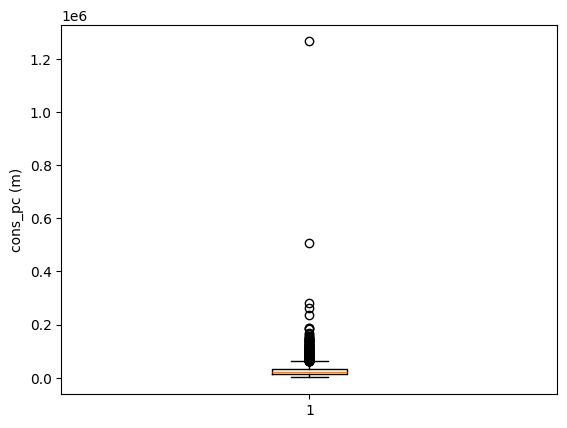

In [320]:
# create a boxplot of outliers to visualise the distribution
plt.boxplot(m_df['cons_pc'])
plt.ylabel('cons_pc (m)');

In [299]:
# take logs of our consumption column in order to dampen the effects of outliers
m_df['cons_pc_log']=m_df['cons_pc'].apply(np.log)

/var/folders/78/kf_z610d5vvb7ch9l49_lghh0000gn/T/ipykernel_32096/2880129187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_df['cons_pc_log']=m_df['cons_pc'].apply(np.log)


In [304]:
m_df['rural'] = merged_df['rural']

/var/folders/78/kf_z610d5vvb7ch9l49_lghh0000gn/T/ipykernel_32096/4055436973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_df['rural'] = merged_df['rural']


In [306]:
m_df.reset_index(inplace=True)

In [308]:
m_df.drop(columns='index',inplace=True)
m_df

/var/folders/78/kf_z610d5vvb7ch9l49_lghh0000gn/T/ipykernel_32096/3993068285.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_df.drop(columns='index',inplace=True)


,cons_pc,cluster_lat,cluster_lon,nightlights,cons_pc_log,rural
0,2983.800049,14.353816,37.890876,0.000000,8.000953,1
1,13578.200195,14.353816,37.890876,0.000000,9.516221,1
2,9280.444336,14.353816,37.890876,0.000000,9.135665,1
3,11704.000000,14.353816,37.890876,0.000000,9.367686,1
4,14974.888672,14.353816,37.890876,0.000000,9.614130,1
...,...,...,...,...,...,...
4712,34352.882812,9.746772,42.308967,0.000000,10.444441,1
4713,66544.000000,9.599389,41.832341,3.519901,11.105619,1
4714,61628.769531,9.746772,42.308967,0.000000,11.028884,1
4715,18916.132812,9.746772,42.308967,0.000000,9.847770,1


In [353]:
# View correlation of consumption, nightlight luminousity, log consumption and rural classification
m_df[['cons_pc','nightlights','cons_pc_log','rural']].corr()

,cons_pc,nightlights,cons_pc_log,rural
cons_pc,1.000000,0.177851,0.693711,0.220842
nightlights,0.177851,1.000000,0.205810,0.489399
cons_pc_log,0.693711,0.205810,1.000000,0.262293
rural,0.220842,0.489399,0.262293,1.000000


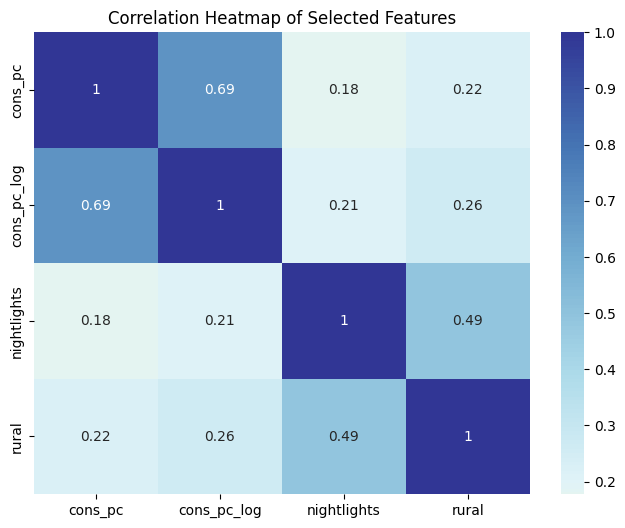

In [382]:
# Compute the correlation matrix
corr_matrix = m_df[['cons_pc', 'cons_pc_log', 'nightlights', 'rural']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu', center=0)

# Add title
plt.title('Correlation Heatmap of Selected Features')

# Show the plot
plt.show()

(0.0, 600000.0)

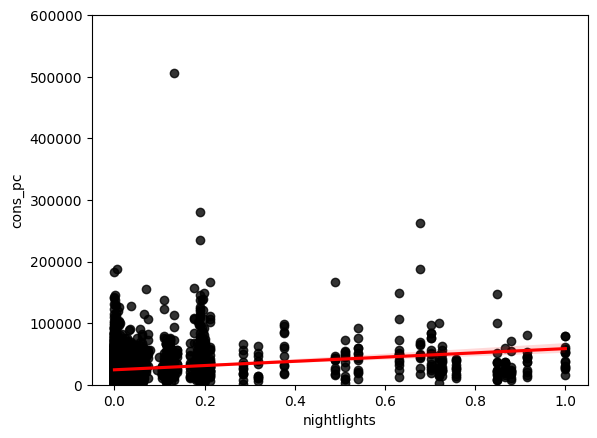

In [383]:
# plot regression of nighttime luminousity and consumption
sns.regplot(m_df,x=X,y=y,scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.ylim(0,600000)

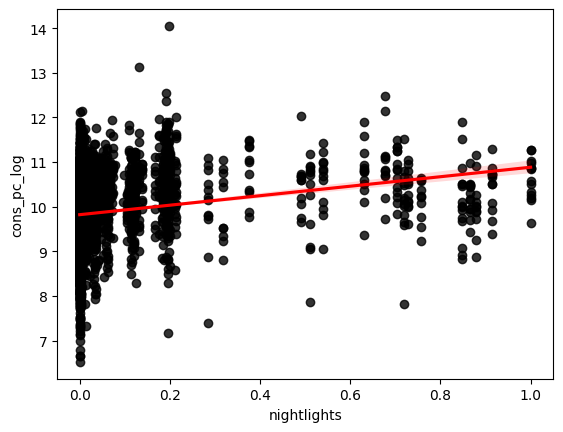

In [355]:
# plot regression of nighttime luminousity and log consumption
sns.regplot(m_df,x=X,y=m_df['cons_pc_log'],scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [349]:
# take nightlight luminousity as our feature (apply normalisation) and take consumption as our target
scaler_m = MinMaxScaler()
X = pd.DataFrame(scaler_m.fit_transform(m_df[['nightlights']]))
y = m_df['cons_pc']

In [350]:
X.rename(columns={0:'nightlights'},inplace=True)

In [291]:
#Instantiate a KFold regression model 
model_w_0s = LinearRegression()

# Define cross-validation strategy
kf = KFold(n_splits=10, shuffle=True)

# Perform cross-validation
scores = cross_val_score(model_w_0s, X, y, cv=kf, scoring=make_scorer(r2_score))

In [292]:
# run a rough CV score on entire dataset
scores.mean()

0.06639521714725012

In [356]:
# view how many households are in a 0 nightlight luminousity cluster
m_df.nightlights.value_counts()

nightlights
0.000000    1672
1.126938      25
0.068200      18
0.613294      15
0.051831      15
            ... 
0.518612       1
0.032562       1
0.302004       1
0.007229       1
2.010110       1
Name: count, Length: 323, dtype: int64

In [235]:
def drop_0s(df):
    """
    Elimina el 90% de las filas donde la columna 'nightlights' es igual a 0 de forma aleatoria.

    Args:
    df (pandas.DataFrame): DataFrame de entrada que contiene una columna 'nightlights'.

    Returns:
    pandas.DataFrame: DataFrame con el 90% de las filas con 'nightlights' igual a 0 eliminadas.
    """
    # Filtrar filas donde 'nightlights' es igual a 0
    zero_nightlights = df[df['nightlights'] == 0]
    
    # Calcular el número de filas a mantener (10% de las filas con 'nightlights' igual a 0)
    n_keep = int(0.1 * len(zero_nightlights))
    
    # Seleccionar aleatoriamente el 10% de las filas para mantener
    rows_to_keep = zero_nightlights.sample(n=n_keep, random_state=42)
    
    # Filtrar filas donde 'nightlights' no es igual a 0
    non_zero_nightlights = df[df['nightlights'] != 0]
    
    # Concatenar las filas no cero con las 10% de filas cero seleccionadas para mantener
    new_df = pd.concat([non_zero_nightlights, rows_to_keep])
    
    # Opcional: Reordenar el DataFrame final
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    
    return new_df

In [357]:
# drop 90% of 0s on a random basis
m_df_less_0s = drop_0s(m_df)

In [359]:
len(m_df_less_0s)

3212

In [365]:
# extract z-score outlier indices after 0s have been dropped
z_score_outliers(m_df_less_0s['cons_pc'])

array([ 211,  441,  454,  633,  792,  834,  891,  993, 1148, 1236, 1428,
       1514, 1597, 1793, 1839, 1844, 1999, 2164, 2219, 2245, 2617, 2646,
       2771, 2906, 2961, 3063, 3185])

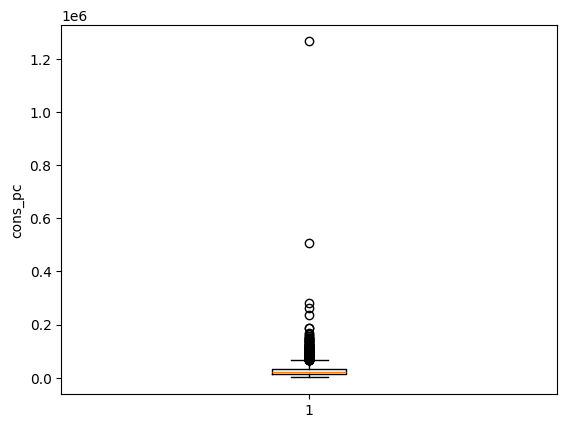

In [358]:
# visualise outliers
plt.boxplot(m_df_less_0s['cons_pc'])
plt.ylabel('cons_pc');

In [282]:
# Redefine our feature and target having stripped out 90% of zeros on random basis
X_0s = pd.DataFrame(scaler_m.transform(m_df_less_0s[['nightlights']]))
y_0s = m_df_less_0s['cons_pc']

In [285]:
X_0s.rename(columns={0:'nightlights'},inplace=True)

In [384]:
# view correlation matrix with zeros removed
m_df_less_0s[['cons_pc','cons_pc_log','nightlights','rural']].corr()

,cons_pc,cons_pc_log,nightlights,rural
cons_pc,1.000000,0.673264,0.170358,0.206709
cons_pc_log,0.673264,1.000000,0.220174,0.271845
nightlights,0.170358,0.220174,1.000000,0.459532
rural,0.206709,0.271845,0.459532,1.000000


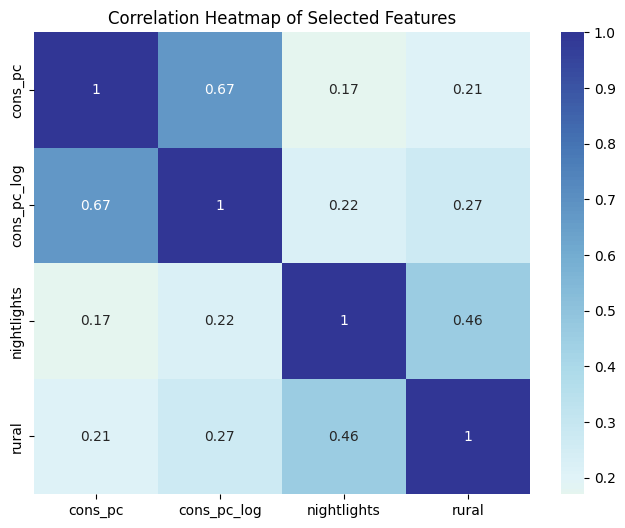

In [386]:
# Compute the correlation matrix
corr_matrix_0s = m_df_less_0s[['cons_pc', 'cons_pc_log', 'nightlights', 'rural']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(corr_matrix_0s, annot=True, cmap='RdYlBu', center=0)

# Add title
plt.title('Correlation Heatmap of Selected Features')

# Show the plot
plt.show()

(0.0, 600000.0)

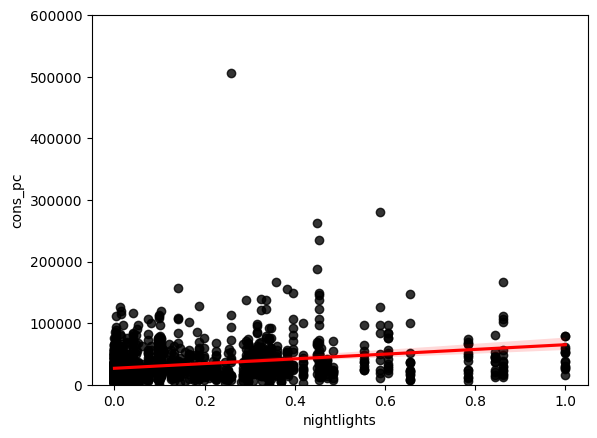

In [366]:
# visualise the regression after the zeros have been dropped
sns.regplot(m_df_less_0s,x=X_0s,y=y_0s,scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.ylim(0,600000)

In [367]:
# Re-run a rough cross validation
model_less_0s = LinearRegression()

# Define cross-validation strategy
kf = KFold(n_splits=10, shuffle=True)

# Perform cross-validation
scores = cross_val_score(model_less_0s, X_0s, y_0s, cv=kf, scoring=make_scorer(r2_score))

In [368]:
scores.mean()

0.06425557349872722

In [390]:
#K-fold CV without data leakage
def k_fold_cv(df):
    #isolate nightlights and cons_pc columns
    df = df[['nightlights','cons_pc']]
    
    #train test split
    train_data, test_data = train_test_split(df, test_size=0.3)

    #define scaler
    scaler = MinMaxScaler()
    
    # Ready X's and y's
    X_train = pd.DataFrame(scaler.fit_transform(train_data[['nightlights']]))
    y_train = train_data['cons_pc']

    X_test = pd.DataFrame(scaler.fit_transform(test_data[['nightlights']]))
    y_test = test_data['cons_pc']
    n_split = 10
    len_split = int(df.shape[0]/n_split)

    # Initialize the 1st fold
    scores = []
    start = 0
    stop = len_split

    # Start the n-split fold CV
    for k in range(n_split): # k in [0,1,2,3,4]
        data_val = df.iloc[start:stop, :]
        data_train = df.drop(index=data_val.index)
        y_train = data_train['cons_pc']
        X_train = data_train.drop(columns=['cons_pc'])
        y_val = data_val['cons_pc']
        X_val = data_val.drop(columns=['cons_pc'])
        
        #fit model
        model_k = LinearRegression()
        model_k.fit(X_train, y_train)
        
        #append score to scores list
        scores.append(model_k.score(X_val, y_val))
        
        # Setup next fold
        start = stop
        stop += len_split

    # Display the mean score and the scores standard deviation
    print(np.array(scores).mean())
    print(np.array(scores).std())

In [391]:
k_fold_cv(m_df)

-0.504749723158484
1.418049859599829


In [392]:
k_fold_cv(m_df_less_0s)

0.04369909393695544
0.028224420431930863


## Analysis and Modelling with Mean Consumption per Nightlight Cluster

In [402]:
data = pd.read_csv('raw_data/ethiopia_10_by_10_ready.csv', sep=',')

In [403]:
data.dtypes

country         object
cluster_lat    float64
cluster_lon    float64
cons_pc        float64
nightlights    float64
dtype: object

In [404]:
data['nightlights'].astype('float64').value_counts()

nightlights
0.000000    197
0.020875      2
0.107431      2
0.008249      2
0.070480      2
           ... 
0.032912      1
0.002156      1
0.001243      1
0.031277      1
0.000624      1
Name: count, Length: 322, dtype: int64

In [405]:
data_0s = drop_0s(data)
data_0s.head(3)

,country,cluster_lat,cluster_lon,cons_pc,nightlights
0,eth,11.143601,39.632585,21.654894,0.642540
1,eth,7.190572,35.422831,5.432886,0.130728
2,eth,7.063881,37.719302,15.957732,0.054990


In [406]:
data_0s['nightlights'].value_counts()

nightlights
0.000000     19
0.642540      2
0.107431      2
0.070480      2
0.020875      2
             ..
0.041769      1
12.277067     1
0.308062      1
0.242306      1
0.023331      1
Name: count, Length: 322, dtype: int64

In [408]:
# Initiate the scaler
scaler = MinMaxScaler()

In [412]:
# Initiate X (apply scaler) and y
X = pd.DataFrame(scaler.fit_transform(data_0s[['nightlights']]))
y = data_0s['cons_pc']

In [413]:
# Reinstantiate column name on X
X.rename(columns={0:'nightlights'},inplace=True)
len(X)

345

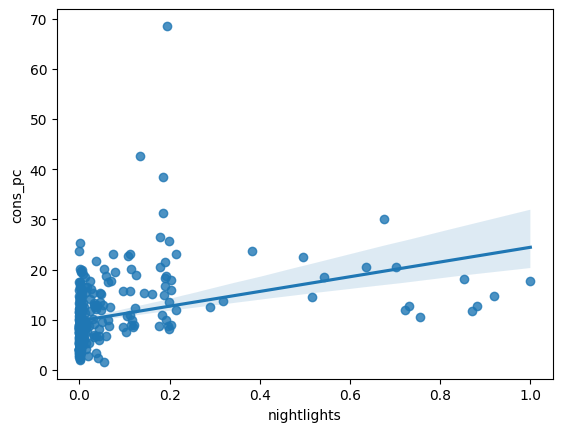

In [414]:
sns.regplot(x=X,y=y);

In [417]:
model = LinearRegression()
k_folds = KFold(n_splits=10)
scores = cross_val_score(model, X, y, cv = k_folds)
scores.mean()

0.020740601918862445

In [418]:
scores

array([ 0.07323808,  0.17626738,  0.08066292,  0.04298103,  0.28507829,
        0.18813309,  0.02241653,  0.06157511, -0.0415061 , -0.68144032])

In [420]:
data_Xy = data_0s[['nightlights','cons_pc']]

In [421]:
data_Xy.head()

,nightlights,cons_pc
0,0.642540,21.654894
1,0.130728,5.432886
2,0.054990,15.957732
3,0.962473,1.598231
4,0.561938,12.994352


In [422]:
data_Xy.corr()

,nightlights,cons_pc
nightlights,1.000000,0.348377
cons_pc,0.348377,1.000000


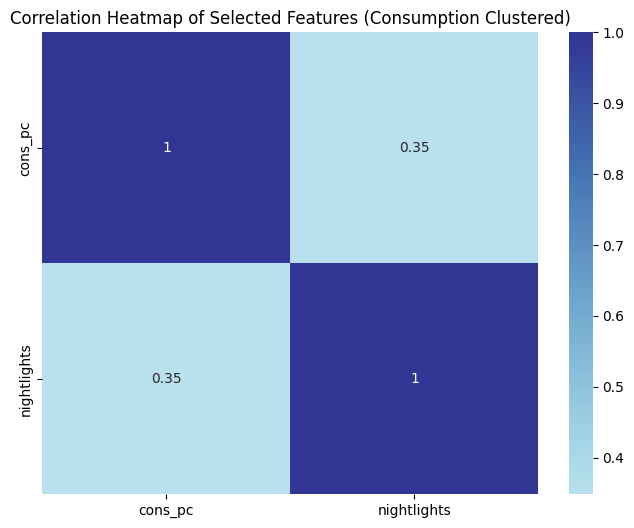

In [425]:
# Compute the correlation matrix
corr_matrix_clus_0s = data_Xy[['cons_pc', 'nightlights']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(corr_matrix_clus_0s, annot=True, cmap='RdYlBu', center=0)

# Add title
plt.title('Correlation Heatmap of Selected Features (Consumption Clustered)')

# Show the plot
plt.show()

In [427]:
k_fold_cv(data_Xy)

-0.006092053189244306
0.3003237794973373


In [428]:
data['nightlights'] = scaler.transform(data[['nightlights']])

In [429]:
data

,country,cluster_lat,cluster_lon,cons_pc,nightlights
0,eth,3.455701,39.515994,14.854634,0.000000
1,eth,3.549937,39.184234,14.312022,0.000000
2,eth,3.864243,39.101366,12.470145,0.000000
3,eth,3.982931,38.491368,8.336539,0.000000
4,eth,4.048194,41.930928,4.762526,0.000000
...,...,...,...,...,...
518,eth,14.288590,38.210252,13.926005,0.001364
519,eth,14.300796,39.059489,6.882396,0.000159
520,eth,14.319217,39.271599,5.894326,0.001712
521,eth,14.353816,37.890876,8.197660,0.000036


In [430]:
addis_ab_df = data[
    (data['cluster_lat'] >= 8.9) & (data['cluster_lat'] <= 9.1) &
    (data['cluster_lon'] >= 38.7) & (data['cluster_lon'] <= 38.9)
]

In [431]:
addis_ab_df

,country,cluster_lat,cluster_lon,cons_pc,nightlights
210,eth,8.954261,38.776901,30.038594,0.675716
211,eth,8.957485,38.762128,10.622940,0.755613
212,eth,8.958031,38.748086,12.825229,0.730208
213,eth,8.964058,38.721902,20.488550,0.634796
216,eth,8.989751,38.773653,17.768381,1.000000
219,eth,9.013835,38.741334,14.816839,0.918602
220,eth,9.015257,38.813750,20.499866,0.702203
222,eth,9.018709,38.789997,12.782309,0.880685
223,eth,9.020116,38.733379,18.206968,0.851894
224,eth,9.023574,38.784249,11.709447,0.871594


In [432]:
#Get co-ords for city boundaries of next 10 most populous cities

dire_dawa_df = data[
    (data['cluster_lat'] >= 9.57) & (data['cluster_lat'] <= 9.64) &
    (data['cluster_lon'] >= 41.8) & (data['cluster_lon'] <= 41.9)
]
mekelle_df = data[
    (data['cluster_lat'] >= 13.45) & (data['cluster_lat'] <= 13.53) &
    (data['cluster_lon'] >= 39.4) & (data['cluster_lon'] <= 39.5)
]
adama_df = data[
    (data['cluster_lat'] >= 8.49) & (data['cluster_lat'] <= 8.59) &
    (data['cluster_lon'] >= 39.2) & (data['cluster_lon'] <= 39.3)
]
awassa_df = data[
    (data['cluster_lat'] >= 7.0) & (data['cluster_lat'] <= 7.11) &
    (data['cluster_lon'] >= 38.46) & (data['cluster_lon'] <= 38.53)
]
bahir_dar_df = data[
    (data['cluster_lat'] >= 11.53) & (data['cluster_lat'] <= 11.63) &
    (data['cluster_lon'] >= 37.3) & (data['cluster_lon'] <= 37.47)
]
gonder_df = data[
    (data['cluster_lat'] >= 12.57) & (data['cluster_lat'] <= 12.63) &
    (data['cluster_lon'] >= 37.43) & (data['cluster_lon'] <= 37.485)
]
dessie_df = data[
    (data['cluster_lat'] >= 11.09) & (data['cluster_lat'] <= 11.17) &
    (data['cluster_lon'] >= 39.61) & (data['cluster_lon'] <= 39.66)
]
jimma_df = data[
    (data['cluster_lat'] >= 7.65) & (data['cluster_lat'] <= 7.703) &
    (data['cluster_lon'] >= 36.8) & (data['cluster_lon'] <= 36.87)
]
jijiga_df = data[
    (data['cluster_lat'] >= 9.33) & (data['cluster_lat'] <= 9.374) &
    (data['cluster_lon'] >= 42.77) & (data['cluster_lon'] <= 42.823)
]
shashamane_df = data[
    (data['cluster_lat'] >= 7.16) & (data['cluster_lat'] <= 7.233) &
    (data['cluster_lon'] >= 38.56) & (data['cluster_lon'] <= 38.65)
]

In [433]:
second_eleventh_city_df = pd.concat([dire_dawa_df,mekelle_df,adama_df,awassa_df,bahir_dar_df,gonder_df,dessie_df,jimma_df,jijiga_df,shashamane_df],axis=0)

In [434]:
second_eleventh_city_df.reset_index(drop=True,inplace=True)

In [435]:
second_eleventh_city_df.head(3)

,country,cluster_lat,cluster_lon,cons_pc,nightlights
0,eth,9.580849,41.852120,12.376362,0.123268
1,eth,9.592109,41.874382,22.719716,0.108270
2,eth,9.592166,41.888189,15.654187,0.097109


In [436]:
k_fold_cv(second_eleventh_city_df)

-1.0278544292028662
0.9599852953978512


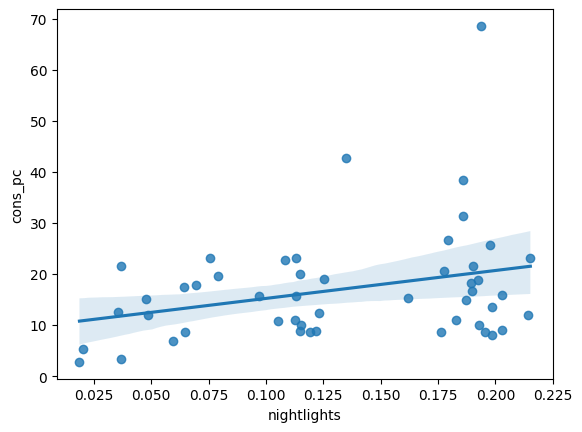

In [437]:
sns.regplot(x=second_eleventh_city_df[['nightlights']],y=second_eleventh_city_df['cons_pc']);

In [438]:
second_eleventh_city_df.drop(columns=['country','cluster_lat','cluster_lon']).corr()

,cons_pc,nightlights
cons_pc,1.000000,0.299529
nightlights,0.299529,1.000000


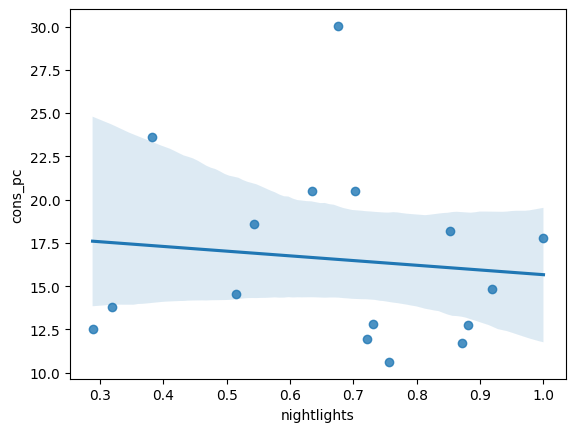

In [439]:
sns.regplot(x=addis_ab_df[['nightlights']],y=addis_ab_df['cons_pc']);

In [440]:
addis_ab_df.drop(columns=['country','cluster_lat','cluster_lon']).corr()

,cons_pc,nightlights
cons_pc,1.00000,-0.11215
nightlights,-0.11215,1.00000


In [441]:
all_cities_df = pd.concat([addis_ab_df,second_eleventh_city_df],axis=0)

In [442]:
all_cities_df.reset_index(drop=True,inplace=True)

In [443]:
all_cities_df.head(3)

,country,cluster_lat,cluster_lon,cons_pc,nightlights
0,eth,8.954261,38.776901,30.038594,0.675716
1,eth,8.957485,38.762128,10.622940,0.755613
2,eth,8.958031,38.748086,12.825229,0.730208


In [444]:
all_cities_df.drop(columns=['country','cluster_lat','cluster_lon']).corr()

,cons_pc,nightlights
cons_pc,1.000000,0.029402
nightlights,0.029402,1.000000
